In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import signal

from convnwb.io import load_nwbfile,make_session_name

from spiketools.spatial.occupancy import (compute_occupancy, compute_trial_occupancy,compute_bin_edges,
                                          compute_bin_counts_pos, normalize_bin_counts)
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.spatial.utils import compute_pos_ranges, get_position_xy
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot, save_figure
from spiketools.plts.trials import plot_rasters
from spiketools.plts.spatial import plot_heatmap, plot_positions, plot_position_by_time,create_heatmap_title
from spiketools.plts.annotate import add_vlines, add_hlines,color_pvalue
from spiketools.plts.data import plot_bar, plot_hist, plot_text
from spiketools.plts.style import drop_spines
from spiketools.plts.stats import plot_surrogates

from spiketools.utils.extract import (get_range, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_values)
from spiketools.utils.epoch import epoch_spikes_by_range
from spiketools.utils.data import compute_range
from spiketools.utils import set_random_seed
from spiketools.utils.run import create_methods_list

from spiketools.utils.extract import drop_range,reinstate_range

In [2]:
import sys
sys.path.append('../code')
from models import PLACE_MODELS, PLACE_COND_MODELS, create_df_place, create_df_place_cond, fit_anova_place, fit_anova_place_cond
from utils import get_values_by_times, compute_firing_rates, compute_trial_firing_rates, compute_t_occupancy, circular_shuffle_unit_fr
sys.path.append('../scripts')
from settings import RUN, PATHS,OCCUPANCY,OCCUPANCY_TRIAL, PLACE,UNITS,METHODS, SURROGATES,BINS

In [3]:

from scipy.io import loadmat
data = loadmat('/Users/weijiazhang/Data/Train/data_matfile/EU001_0_train_events.mat')
#behavioral_data = pd.read_csv('/Users/weijiazhang/Data/Train/events/events.csv')



## Settings

In [4]:
epochSize = 0.1
numBins = 40
kernelSize = 8
numBinsPos = 40
numBinsSpeed = 25

units = 0

In [5]:
# Get behavioral data
df = pd.DataFrame(data['events']['events'][0][0][0])
# Convert object columns to string type
str_cols = ['subj', 'object','timesfile']
for col in str_cols:
    df[col] = df[col].str[0].astype(str)
# Convert numeric columns to appropriate types
int_cols = ['session', 'trialNum', 'blockType', 'driveType'] 
float_cols = ['object_position', 'response_position', 'response_mstime', 'timesoffset','mstime', 'position','speed']
for col in int_cols:
    df[col] = df[col].str[0].astype(int)
for col in float_cols:
    df[col] = df[col].str[0].astype(float)

behavioral_data = df


In [6]:
time_offset = df['timesoffset'][1]
time_offset

130528.36197916667

In [7]:
df

,subj,session,trialNum,blockType,driveType,object,object_position,response_position,response_mstime,wall_position,wall_time,speed,constant_speed,position,mstime,lfpfile,lfpmstime,lfpoffset,timesfile,timesoffset
0,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],0.762502,[[0]],-33.978800,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[260857]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.304284e+05
1,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],1.599019,[[0]],-33.881600,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[261057]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.305284e+05
2,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],2.439726,[[0]],-33.700350,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[261257]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.306284e+05
3,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],3.284622,[[0]],-33.434567,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[261457]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.307284e+05
4,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],4.122536,[[0]],-33.084567,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[261657]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.308284e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656,EU001,0,64,2,1,box.egg,-21.39580,-20.4225,1.504233e+12,[[33.4368]],[[1504233190599.0]],4.245552,[[0]],31.811217,1.504233e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[4432110]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,2.216055e+06
7657,EU001,0,64,2,1,box.egg,-21.39580,-20.4225,1.504233e+12,[[33.4368]],[[1504233190599.0]],3.760890,[[0]],32.224200,1.504233e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[4432310]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,2.216155e+06
7658,EU001,0,64,2,1,box.egg,-21.39580,-20.4225,1.504233e+12,[[33.4368]],[[1504233190599.0]],3.331555,[[0]],32.589833,1.504233e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[4432510]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,2.216255e+06
7659,EU001,0,64,2,1,box.egg,-21.39580,-20.4225,1.504233e+12,[[33.4368]],[[1504233190599.0]],2.951233,[[0]],32.913717,1.504233e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[4432710]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,2.216355e+06


## Extract Spikes

In [8]:

# Access spikeTimes from the nested structured array
spike_times = data['events']['spikeData'][0][0]['spikeTimes'][0][0][0][units]
print("Spike times shape:", spike_times.shape)
spike_times

Spike times shape: (24800, 1)


array([[1.61800002e+02],
       [2.29866670e+02],
       [4.36766673e+02],
       ...,
       [2.29196837e+06],
       [2.29206330e+06],
       [2.29232157e+06]])

In [9]:
positions = behavioral_data['position']


In [10]:
# This line appears to be MATLAB code trying to access a timesoffset field
# In the Python context, we already have this value in behavioral_data['timesoffset'][1]
# as shown in the cell above where we print that value
behavioral_data['timesoffset'][1]

130528.36197916667

## Extract Firing Rate Data 
- N epochs x N neurons
- Each epoch is 100ms

In [11]:
units = 1

In [12]:
events_fr = data['events']['fr'][0][0]
events_fr.shape

(7661, 21)

In [13]:
speeds = np.array(behavioral_data['speed'])
bad = speeds < 2

In [14]:
# Get speeds and create mask for valid speeds (>= 2)
speeds = np.array(behavioral_data['speed'])
bad = speeds < 2
# Apply mask to events_fr, ensuring dimensions match
behavioral_data = behavioral_data[~bad]
events_fr = events_fr[~bad,:]

In [15]:
units_fr = events_fr[:,units]
len(events_fr[1])


21

## Extract Position Data 

In [16]:
positions = behavioral_data['position']
positions = (positions + 34) / 68  # Normalize to 0-1 range
positions[positions < 0] = 0  # Clip values below 0
positions[positions > 1] = 1 
positions 

2       0.004407
3       0.008315
4       0.013462
5       0.019824
6       0.027399
          ...   
7656    0.967812
7657    0.973885
7658    0.979262
7659    0.984025
7660    0.988247
Name: position, Length: 7359, dtype: float64

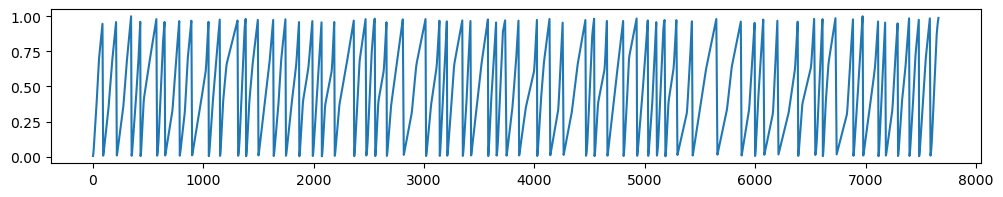

In [17]:
fig,ax = plt.subplots(1,1,figsize=(12,2))
plt.plot(positions)

### Bin positions into percentage along the track

In [18]:
edges_pos = np.linspace(0, 100, numBinsPos+1)
pos_bin = np.digitize(positions*100, edges_pos)


count, _ = np.histogram(positions*100, bins=edges_pos)

## Occupancy

In [19]:
# figure out how long in each bin (in s)
# edges = np.linspace(0, 100, numBins+1)
# position_scaled = positions * 100
#edges_with_extra = np.append(edges, 101)
#
#pos_bin = np.digitize(position_scaled, edges_with_extra, right=True)
counts = count[:numBins]
occ = counts * epochSize
pos_bin.shape

(7359,)

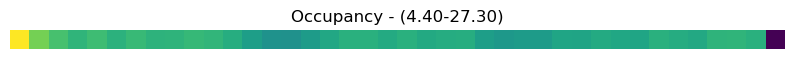

In [20]:
plot_heatmap(occ, title= create_heatmap_title('Occupancy', occ), figsize=(10, 6))

## Smoothing Kernel

In [21]:
g = signal.windows.gaussian(kernelSize, std=1)
g = g/np.sum(g)


## Compute Smoothed Firing Rates

In [22]:
# def compute_firing_rates(units_fr, pos_bin, occ, g, numBins, epochSize):
#     """
#     Calculate place bins with smoothed firing rates
    
#     Parameters:
#     -----------
#     units_fr : ndarray
#         Firing rate matrix
#     pos_bin : ndarray
#         Position bin assignments
#     occ : ndarray
#         Occupancy time in each bin
#     g : ndarray
#         Gaussian smoothing kernel
#     numBins : int
#         Number of position bins
#     epochSize : float
#         Size of each time epoch in seconds
        
#     Returns:
#     --------
#     place_bins : ndarray
#         Smoothed firing rates across position bins
#     """
#     epoch_spikes = units_fr * epochSize
    
#     # Count spikes in each position bin
#     df = pd.DataFrame({
#         'pos_bin': pos_bin,
#         'fr_value': epoch_spikes
#     })
#     spike_count_by_position = df.groupby('pos_bin')['fr_value'].sum()
#     spike_count_by_position_array = spike_count_by_position.values
#     smoothed_spike_count = signal.convolve(spike_count_by_position_array, g, mode='same')
    
#     if len(smoothed_spike_count) != numBins:
#         empty_bins = occ == 0
#         occ = occ[~empty_bins]
#         smoothed_spike_count = smoothed_spike_count[:-1]
        
#     smoothed_occ = signal.convolve(occ, g, mode='same')
#     place_bins = smoothed_spike_count/smoothed_occ
#     place_bins[smoothed_occ < 0.1] = np.nan
    
#     return place_bins

In [23]:
place_bins = compute_firing_rates(units_fr, pos_bin, occ, g, numBins, epochSize)

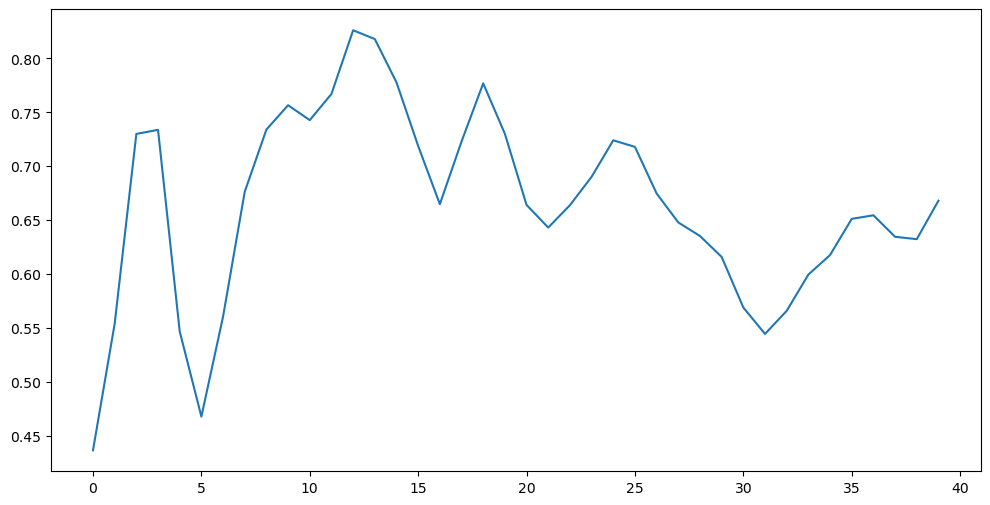

In [24]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.plot(place_bins)

## Compute Smoothed Firing Rates by Trial

In [31]:
# Bin by trial number
edges_trial = np.arange(0.5, 65, 1)  # 0.5:1:65 in MATLAB
trial_bin = np.array(behavioral_data['trialNum'])

In [71]:
behavioral_data

,subj,session,trialNum,blockType,driveType,object,object_position,response_position,response_mstime,wall_position,wall_time,speed,constant_speed,position,mstime,lfpfile,lfpmstime,lfpoffset,timesfile,timesoffset
2,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],2.439726,[[0]],-33.700350,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[261257]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.306284e+05
3,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],3.284622,[[0]],-33.434567,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[261457]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.307284e+05
4,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],4.122536,[[0]],-33.084567,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[261657]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.308284e+05
5,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],4.918554,[[0]],-32.651950,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[261857]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.309284e+05
6,EU001,0,1,1,0,desk.egg,-9.35862,-12.3823,1.504231e+12,[[30.6318]],[[1504231113355.0]],5.801156,[[0]],-32.136867,1.504231e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[262057]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,1.310284e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656,EU001,0,64,2,1,box.egg,-21.39580,-20.4225,1.504233e+12,[[33.4368]],[[1504233190599.0]],4.245552,[[0]],31.811217,1.504233e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[4432110]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,2.216055e+06
7657,EU001,0,64,2,1,box.egg,-21.39580,-20.4225,1.504233e+12,[[33.4368]],[[1504233190599.0]],3.760890,[[0]],32.224200,1.504233e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[4432310]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,2.216155e+06
7658,EU001,0,64,2,1,box.egg,-21.39580,-20.4225,1.504233e+12,[[33.4368]],[[1504233190599.0]],3.331555,[[0]],32.589833,1.504233e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[4432510]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,2.216255e+06
7659,EU001,0,64,2,1,box.egg,-21.39580,-20.4225,1.504233e+12,[[33.4368]],[[1504233190599.0]],2.951233,[[0]],32.913717,1.504233e+12,[/data10/eeg/EU001/lfp.noreref/_EU001_Train_1_...,[],[[4432710]],/data10/eeg/EU001/EU001_Train_1_20170929-17314...,2.216355e+06


## Compute Trial Occupancy

In [72]:
# def compute_t_occupancy(trial_bin, pos_bin, edges_trial, edges_pos, epochSize):
#     trial_occupancy = np.zeros((len(edges_trial)-1, len(edges_pos)-1))
#     for t, p in zip(trial_bin, pos_bin):
#         if t > 0 and t <= len(edges_trial)-1 and p > 0 and p <= len(edges_pos)-1:
#             trial_occupancy[t-1, p-1] += epochSize
#     return trial_occupancy

In [73]:
trial_occupancy = compute_t_occupancy(trial_bin, pos_bin, edges_trial, edges_pos, epochSize)

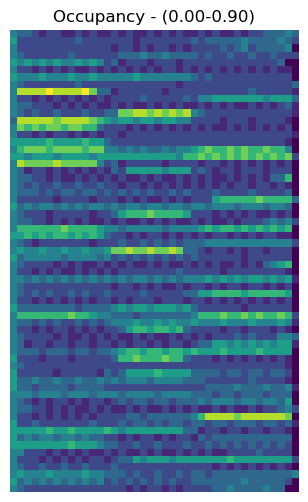

In [74]:
plot_heatmap(trial_occupancy, title= create_heatmap_title('Occupancy', trial_occupancy), figsize=(10, 6))

## Get spike count by trial

In [75]:
# def compute_trial_firing_rates(trial_bin, pos_bin, units_fr, edges_trial, edges_pos, trial_occupancy, kernelSize, epochSize):
#     # Calculate spike counts per trial and position bin
#     trial_spikes = np.zeros((len(edges_trial)-1, len(edges_pos)-1))
#     for t, p, f in zip(trial_bin, pos_bin, units_fr):
#         if t > 0 and t <= len(edges_trial)-1 and p > 0 and p <= len(edges_pos)-1:
#             trial_spikes[t-1, p-1] += f * epochSize

#     # Create and normalize gaussian window
#     g = signal.windows.gaussian(kernelSize, std=1)
#     g = g/np.sum(g) # normalize

#     # Apply smoothing across trials
#     smoothed_trials = np.full(trial_spikes.shape, np.nan) # initialize the smooth spikes per bin per trial
#     smoothed_time_trials = np.full(trial_occupancy.shape, np.nan) # initialize the time per bin per trial
#     for bin in range(trial_spikes.shape[0]):
#         smoothed_trials[bin,:] = signal.filtfilt(g, 1, trial_spikes[bin,:])
#         smoothed_time_trials[bin,:] = signal.filtfilt(g, 1, trial_occupancy[bin,:])

#     # Calculate firing rates and mask low occupancy bins
#     trial_place_bins = smoothed_trials/smoothed_time_trials # get the "pure firing rate"
#     trial_place_bins[smoothed_time_trials < 0.1] = np.nan
    
#     return trial_place_bins

In [76]:
trial_place_bins = compute_trial_firing_rates(trial_bin, pos_bin, units_fr, edges_trial, edges_pos, trial_occupancy, kernelSize, epochSize)

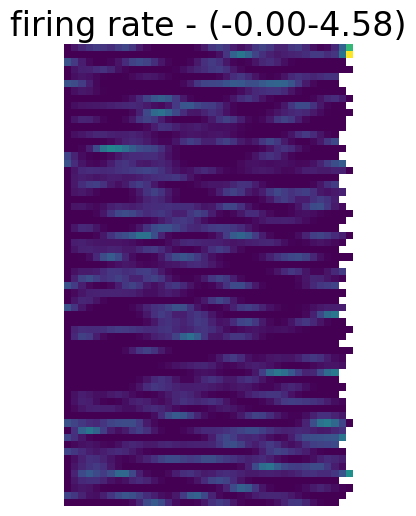

In [89]:
plot_heatmap(trial_place_bins, title= create_heatmap_title('firing rate', trial_place_bins[:,:-3]), figsize=(5, 6))

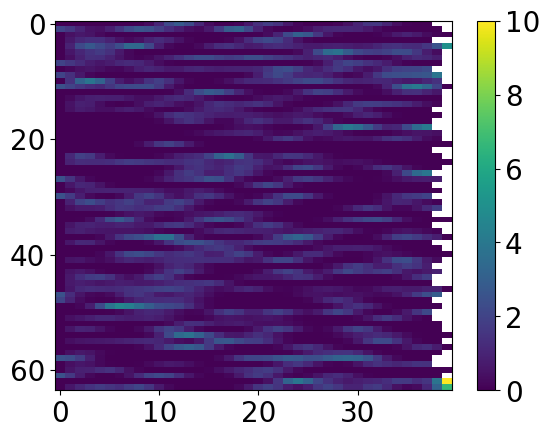

In [90]:
plt.imshow(trial_place_bins[:, :], aspect='auto')

plt.colorbar()
plt.show()

In [98]:
place_bins = np.nanmean(trial_place_bins,axis = 0)
place_sem = np.nanstd(trial_place_bins,axis = 0)/np.sqrt(trial_place_bins.shape[0])

s_bins = np.linspace(0, 40, numBinsPos+1)


## Statistical Analysis

In [99]:
results = {}

### Spatial Information

In [100]:
# Compute mutual information of spiking and location
results['place_info'] = compute_spatial_information(place_bins, occ, normalize=False)
print(results['place_info'])


0.020233685467719177


### ANOVA

In [109]:
# Create the dataframe
df = create_df_place(trial_place_bins[:,:-3])
results['place_anova']= fit_anova_place(df)
# Check the computed place F-value
print('The ANOVA place F-value is {:4.2f}'.format(results['place_anova']))

The ANOVA place F-value is 0.88


In [110]:
# Shuffle settings
shuffle_approach = 'CIRCULAR' # 'ISI', 'BINCIRC'
n_surrogates =1000

In [111]:
# def circular_shuffle_unit_fr(units_fr, n_shuffles=1000):
#     """
#     Perform circular shuffling on event firing rate data
    
#     Parameters
#     ----------
#     event_fr : array-like
#         Array of firing rates for events/trials
#     n_shuffles : int, optional
#         Number of shuffles to perform (default=100)
        
#     Returns
#     -------
#     shuffled : ndarray
#         Array of shuffled firing rates with shape (n_shuffles, len(event_fr))
#     """
#     units_fr = np.array(units_fr)
#     shuffled = np.zeros((n_shuffles, len(units_fr)))
    
#     for i in range(n_shuffles):
#         # Generate random shift amount
#         shift = np.random.randint(0, len(units_fr))
#         # Perform circular shift
#         shuffled[i] = np.roll(units_fr, shift)
        
#     return shuffled

# Create shuffled surrogates
shuffles = circular_shuffle_unit_fr(units_fr, n_surrogates)




In [112]:
surr_analyses = create_methods_list(METHODS)
surrs = {analysis : \
                    np.zeros(SURROGATES['n_shuffles']) for analysis in surr_analyses}


In [113]:
for ind, shuffle in enumerate(shuffles):
    surr_place_bins = compute_firing_rates(shuffle, pos_bin, occ, g, numBins, epochSize)
    surr_trial_place_bins = compute_trial_firing_rates(trial_bin, pos_bin, shuffle, edges_trial, edges_pos, trial_occupancy, kernelSize, epochSize)
    #surr_place_bins= np.nanmean(surr_trial_place_bins,axis = 0)
    surrs['place_info'][ind] = compute_spatial_information(surr_place_bins, occ, normalize=False)
    surrs['place_anova'][ind] = fit_anova_place(create_df_place(surr_trial_place_bins))

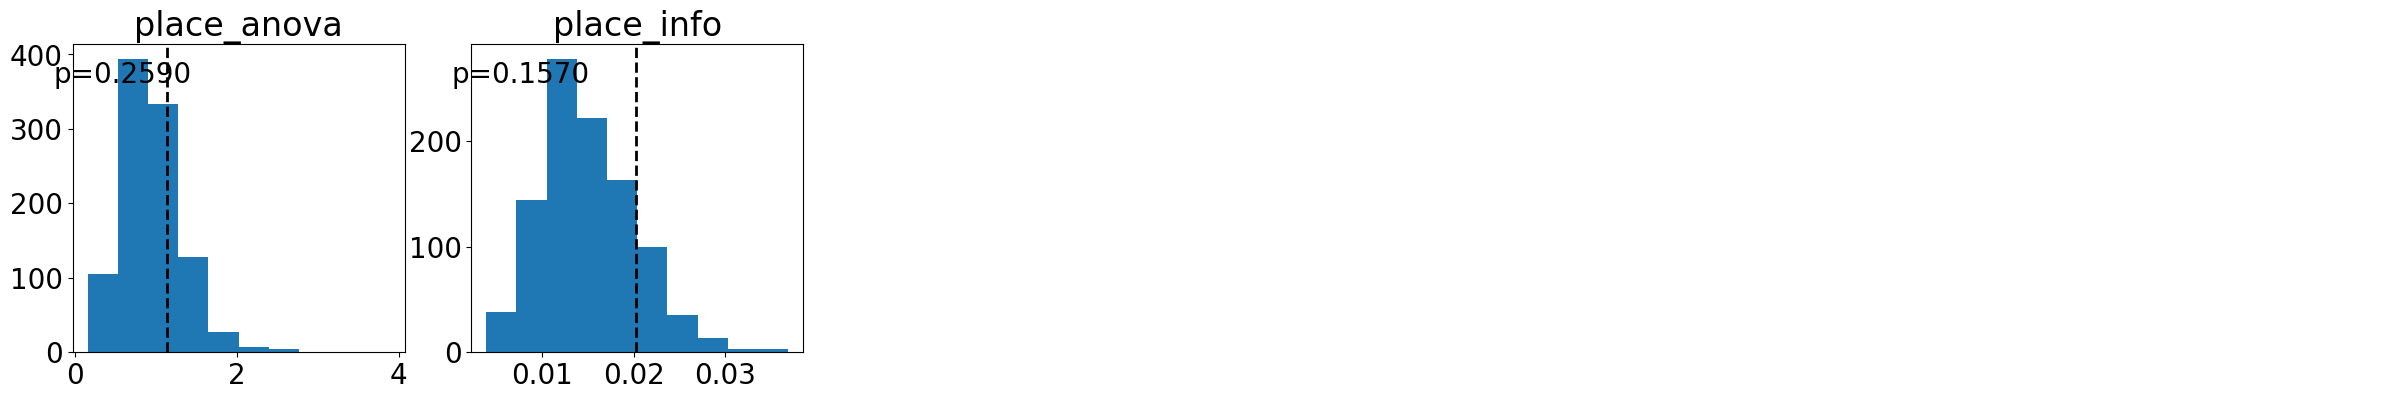

In [106]:
axes = make_axes(2, 6, figsize=(30, 4))
i = 0
for analysis in surr_analyses:
    results[analysis + '_surr_p_val'], results[analysis + '_surr_z_score'] = \
                        compute_surrogate_stats(results[analysis], surrs[analysis],title = analysis,plot = True, ax=axes[i])
    i = i+1


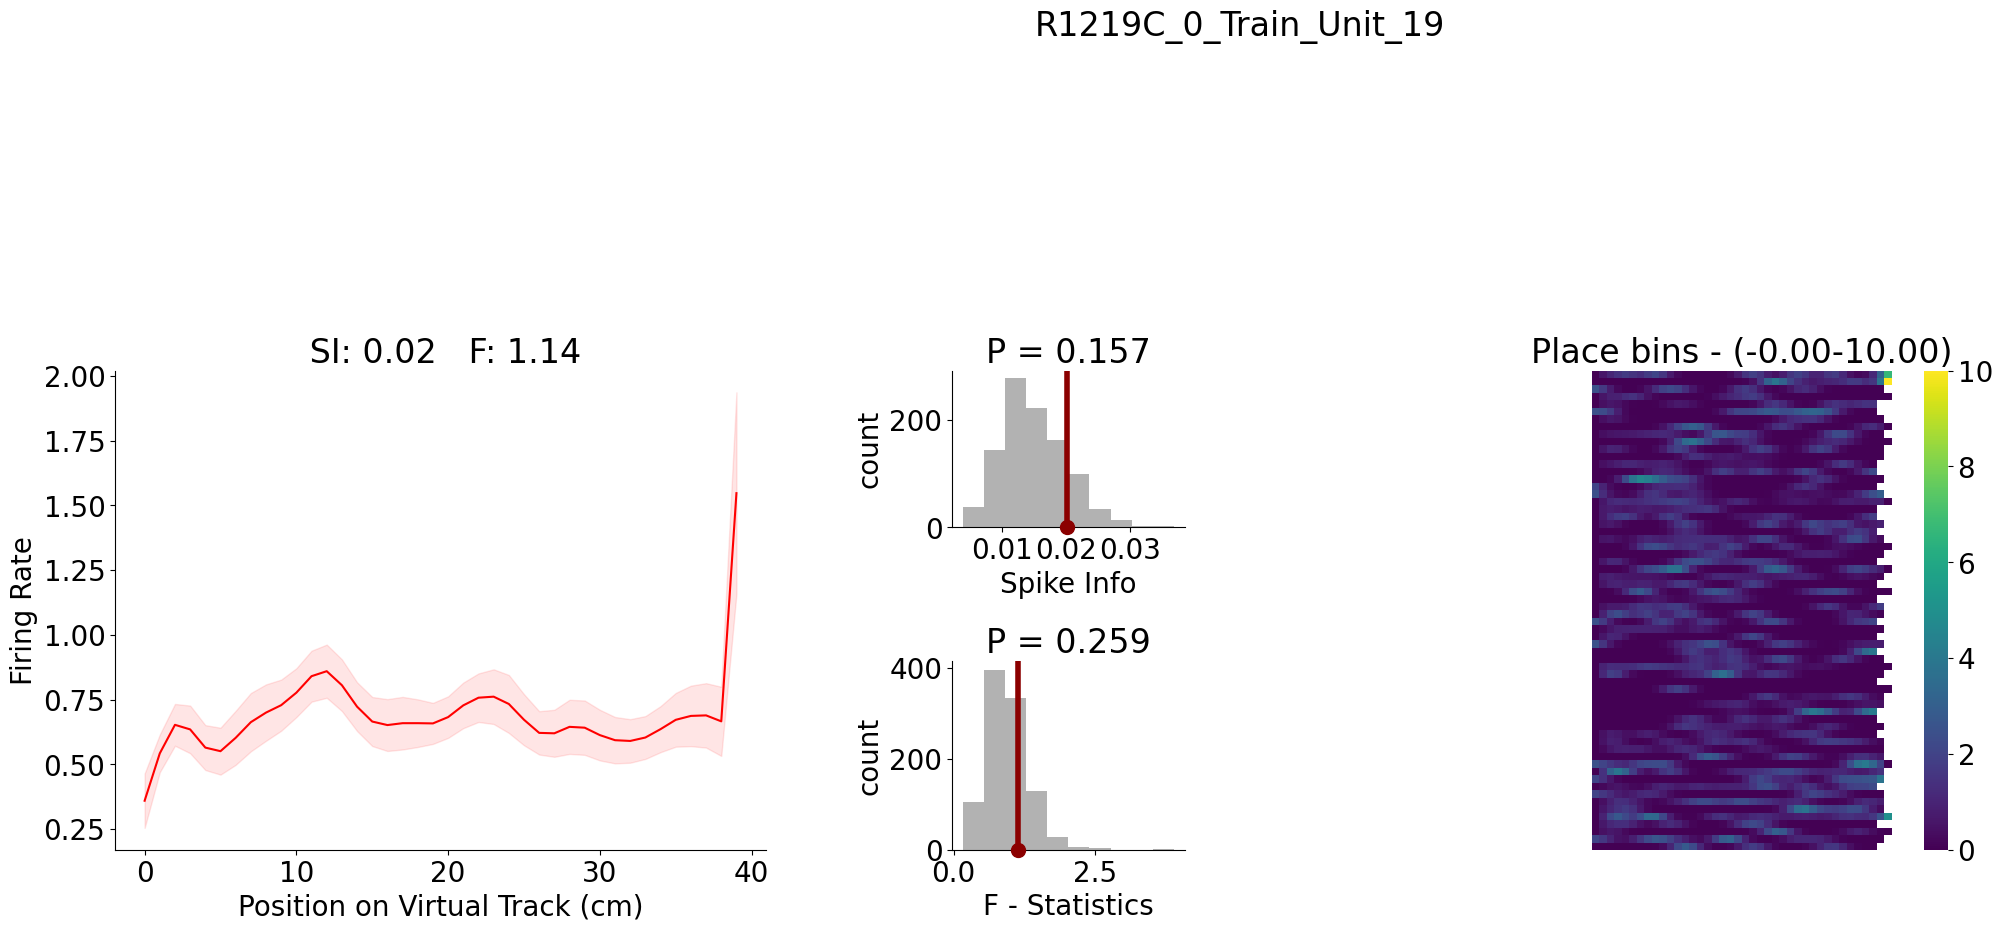

In [108]:
plt.rcParams.update({'font.size': 20})
grid = make_grid(3, 6, wspace=.8, hspace=.8, figsize=(30, 10),
                     height_ratios=[1,1, 1.2],title = 'R1219C_0_Train_Unit_19')

#plt.rcParams.update({'font.size': 25})
SI = results['place_info']
F = results['place_anova']
# ax = get_grid_subplot(grid, 0, slice(0,2))
# plot_rasters(spike_pos,ax = ax, vline=None, figsize=(10, 5),color = 'red',alpha =.3, show_axis=True, title='Forward Trials')
# ax.set_xticklabels([])
# ax.set_xlabel('')
# ax.get_xaxis().set_visible(False)
# drop_spines(['top','right','bottom'],ax = ax)

ax = get_grid_subplot(grid, slice(1,3), slice(0,2))
ax.plot( s_bins[:-1], place_bins, color = 'red', label='Mean Value')
ax.fill_between( s_bins[:-1], place_bins - place_sem, place_bins+ place_sem, color = 'red', alpha=0.1)
ax.set_xlabel('Position on Virtual Track (cm)')
ax.set_ylabel('Firing Rate')
ax.set_title(f' SI: {np.round(SI,2)}   F: {np.round(F,2)}')
drop_spines(['top','right'],ax = ax)

ax = get_grid_subplot(grid, 1, 2)
P = results['place_info_surr_p_val']
plot_surrogates(surrs['place_info'], data_value=SI, p_value=None, title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(SI , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(SI , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('Spike Info')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)

ax = get_grid_subplot(grid, 2, 2)
P = results['place_anova_surr_p_val']
plot_surrogates(surrs['place_anova'], data_value=F, p_value=None ,title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(F , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(F , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('F - Statistics')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)

ax = get_grid_subplot(grid, slice(1,3), slice(3,5))
plot_heatmap(trial_place_bins, cbar=True,title= create_heatmap_title('Place bins', trial_place_bins), ax=ax)





In [35]:
from convnwb.utils.run import catch_error
filename = 'EU001_0_train_events'
results_folder = '/Users/weijiazhang/Data/Train/results'
trial_occupancy = compute_t_occupancy(trial_bin, pos_bin, edges_trial, edges_pos, epochSize)    
print(trial_occupancy)
for unit_ind in range(len(events_fr[1])):
    print('unit_ind',unit_ind)

    
    units_fr = events_fr[:,unit_ind]
    trial_place_bins = compute_trial_firing_rates(trial_bin, pos_bin, units_fr, edges_trial, edges_pos, trial_occupancy, kernelSize, epochSize)
    print(trial_place_bins)         
                # figure out how long in each bin (in s)



[[0.4 0.3 0.2 ... 0.3 0.  0. ]
 [0.5 0.3 0.4 ... 0.3 0.2 0. ]
 [0.4 0.5 0.4 ... 0.3 0.3 0.3]
 ...
 [0.4 0.2 0.2 ... 0.3 0.4 0. ]
 [0.5 0.2 0.2 ... 0.4 0.3 0.2]
 [0.4 0.3 0.3 ... 0.3 0.4 0.3]]
unit_ind 0
[[12.5        12.21207149 11.79499183 ...  4.63295187         nan
          nan]
 [10.          9.56525207 10.42510876 ... 13.11857037 11.10201817
          nan]
 [ 7.5         8.43102557  9.37690144 ...  8.56408709  9.18106886
  10.        ]
 ...
 [ 7.5         8.78272602 10.777297   ... 10.08518498 11.82958917
          nan]
 [ 8.         10.51291844 12.48819115 ... 11.9772832   9.49367282
   5.        ]
 [12.5        10.90682851 10.24492178 ...  5.94641874  8.80492862
  13.33333333]]
unit_ind 1
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.80601149e-03
             nan            nan]
 [2.00000000e+00 1.60581900e+00 9.90292060e-01 ... 3.33096446e-06
  0.00000000e+00            nan]
 [1.63907813e-18 4.54169881e-01 6.56270412e-01 ... 3.45805546e-01
  9.73336229e-02 5.33556568e-1